In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [3]:
df = pd.read_csv("합천_댐기상종합데이터_최종.csv", index_col='시간')
df.index = pd.to_datetime(df.index)
df['홍수기'] = 0
# 인덱스의 월과 일을 이용하여 '홍수기' 열 값 설정
df.loc[(df.index.month >= 6) & (df.index.month <= 9) & (df.index.day >= 21) & (df.index.day <= 20), '홍수기'] = 1

In [4]:
df

,전일유입량,저수량(현재),전일방류량(본댐),저수량차이,2일전유입량,3일전유입량,4일전유입량,5일전유입량,6일전유입량,7일전유입량,...,2일전평균습도(%),3일전평균습도(%),4일전평균습도(%),5일전평균습도(%),6일전평균습도(%),7일전평균습도(%),1일후평균강수량(mm),2일후평균강수량(mm),3일후평균강수량(mm),홍수기
시간,,,,,,,,,,,,,,,,,,,,,
2000-01-01,7.4,513.4,28.9,173.4,5.8,3.5,5.5,6.9,5.0,5.3,...,59.375000,67.791667,66.208333,61.750000,63.208333,51.750000,0.000000,0.000000,0.000000,0
2000-01-02,4.4,512.1,23.7,173.0,7.4,5.8,3.5,5.5,6.9,5.0,...,57.708333,59.375000,67.791667,66.208333,61.750000,63.208333,0.000000,0.000000,0.187500,0
2000-01-03,4.7,509.8,26.1,171.8,4.4,7.4,5.8,3.5,5.5,6.9,...,63.333333,57.708333,59.375000,67.791667,66.208333,61.750000,0.000000,0.187500,1.020833,0
2000-01-04,3.8,508.4,27.3,171.4,4.7,4.4,7.4,5.8,3.5,5.5,...,65.208333,63.333333,57.708333,59.375000,67.791667,66.208333,0.187500,1.020833,0.135417,0
2000-01-05,6.1,506.5,25.2,170.4,3.8,4.7,4.4,7.4,5.8,3.5,...,55.916667,65.208333,63.333333,57.708333,59.375000,67.791667,1.020833,0.135417,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-01,2.7,212.6,1.3,-113.4,2.6,2.8,3.2,3.3,4.6,4.7,...,52.541667,56.958333,53.750000,46.791667,66.125000,76.541667,0.223303,0.255882,0.329789,0
2023-04-02,2.3,212.4,5.0,-113.1,2.7,2.6,2.8,3.2,3.3,4.6,...,43.375000,52.541667,56.958333,53.750000,46.791667,66.125000,0.255882,0.329789,0.871875,0
2023-04-03,2.6,212.2,5.0,-112.7,2.3,2.7,2.6,2.8,3.2,3.3,...,49.875000,43.375000,52.541667,56.958333,53.750000,46.791667,0.329789,0.871875,0.276042,0


In [5]:
df_date = df.assign(month = df.index.month).assign(day_of_week = df.index.dayofweek).assign(week_of_year = df.index.week)

<ipython-input-5-cc327fcf453a>:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_date = df.assign(month = df.index.month).assign(day_of_week = df.index.dayofweek).assign(week_of_year = df.index.week)


In [6]:
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs).drop(columns=[col_name])

df_date = generate_cyclical_features(df_date, 'day_of_week', 7, 0)
df_date = generate_cyclical_features(df_date, 'month', 12, 1)
df_date = generate_cyclical_features(df_date, 'week_of_year', 52, 0)

df_date.head()

,전일유입량,저수량(현재),전일방류량(본댐),저수량차이,2일전유입량,3일전유입량,4일전유입량,5일전유입량,6일전유입량,7일전유입량,...,1일후평균강수량(mm),2일후평균강수량(mm),3일후평균강수량(mm),홍수기,sin_day_of_week,cos_day_of_week,sin_month,cos_month,sin_week_of_year,cos_week_of_year
시간,,,,,,,,,,,,,,,,,,,,,
2000-01-01,7.4,513.4,28.9,173.4,5.8,3.5,5.5,6.9,5.0,5.3,...,0.000000,0.000000,0.000000,0,-0.974928,-0.222521,0.0,1.0,6.432491e-16,1.000000
2000-01-02,4.4,512.1,23.7,173.0,7.4,5.8,3.5,5.5,6.9,5.0,...,0.000000,0.000000,0.187500,0,-0.781831,0.623490,0.0,1.0,6.432491e-16,1.000000
2000-01-03,4.7,509.8,26.1,171.8,4.4,7.4,5.8,3.5,5.5,6.9,...,0.000000,0.187500,1.020833,0,0.000000,1.000000,0.0,1.0,1.205367e-01,0.992709
2000-01-04,3.8,508.4,27.3,171.4,4.7,4.4,7.4,5.8,3.5,5.5,...,0.187500,1.020833,0.135417,0,0.781831,0.623490,0.0,1.0,1.205367e-01,0.992709
2000-01-05,6.1,506.5,25.2,170.4,3.8,4.7,4.4,7.4,5.8,3.5,...,1.020833,0.135417,0.000000,0,0.974928,-0.222521,0.0,1.0,1.205367e-01,0.992709


In [7]:
#df = df[['전일유입량', '전일방류량(본댐)', '평균강수량(mm)', '당일유입량', '1일후유입량', '2일후유입량']]
df_date = df_date[['전일유입량', '저수량(현재)', '평균기온(°C)', '평균습도(%)', '전일방류량(본댐)', '평균강수량(mm)', '홍수기', 'sin_day_of_week', 'cos_day_of_week', 'sin_month', 'cos_month', 'sin_week_of_year', 'cos_week_of_year', '당일유입량', '1일후유입량', '2일후유입량']]
#df.head(5)

In [8]:
df_date.columns

Index(['전일유입량', '저수량(현재)', '평균기온(°C)', '평균습도(%)', '전일방류량(본댐)', '평균강수량(mm)',
       '홍수기', 'sin_day_of_week', 'cos_day_of_week', 'sin_month', 'cos_month',
       'sin_week_of_year', 'cos_week_of_year', '당일유입량', '1일후유입량', '2일후유입량'],
      dtype='object')

In [9]:
# 열의 순서를 조정하기 위해 열의 리스트 생성
columns = list(df_date.columns)

# '당일유입량', '1일후유입량', '2일후유입량' 열(Column)을 맨 뒤로 이동
#columns += ['당일유입량', '1일후유입량', '2일후유입량']
columns = [col for col in columns if col not in ['당일유입량', '1일후유입량', '2일후유입량']]

# 열 순서 조정한 DataFrame 생성
df_date = df_date[columns + ['당일유입량', '1일후유입량', '2일후유입량']]
df_date.columns

Index(['전일유입량', '저수량(현재)', '평균기온(°C)', '평균습도(%)', '전일방류량(본댐)', '평균강수량(mm)',
       '홍수기', 'sin_day_of_week', 'cos_day_of_week', 'sin_month', 'cos_month',
       'sin_week_of_year', 'cos_week_of_year', '당일유입량', '1일후유입량', '2일후유입량'],
      dtype='object')

In [10]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_date)
#scaler.fit(train)
#train_scaled = scaler.transform(train)
#test_scaled = scaler.transform(test)

In [11]:
df_scaled = pd.DataFrame(data=scaled_data, columns=df_date.columns, index=df_date.index.values)
df_scaled.head()

,전일유입량,저수량(현재),평균기온(°C),평균습도(%),전일방류량(본댐),평균강수량(mm),홍수기,sin_day_of_week,cos_day_of_week,sin_month,cos_month,sin_week_of_year,cos_week_of_year,당일유입량,1일후유입량,2일후유입량
2000-01-01,0.003900,0.582187,0.347890,0.553127,0.017042,0.000000,0.0,0.000000,0.356896,0.5,1.0,0.500000,1.000000,0.002319,0.002477,0.002003
2000-01-02,0.002319,0.580059,0.421855,0.576004,0.013976,0.000000,0.0,0.099031,0.801938,0.5,1.0,0.500000,1.000000,0.002477,0.002003,0.003215
2000-01-03,0.002477,0.576293,0.302154,0.462633,0.015391,0.000000,0.0,0.500000,1.000000,0.5,1.0,0.560268,0.996354,0.002003,0.003215,0.004217
2000-01-04,0.002003,0.574001,0.273040,0.474835,0.016099,0.000000,0.0,0.900969,0.801938,0.5,1.0,0.560268,0.996354,0.003215,0.004217,0.003373
2000-01-05,0.003215,0.570891,0.345530,0.546518,0.014860,0.005805,0.0,1.000000,0.356896,0.5,1.0,0.560268,0.996354,0.004217,0.003373,0.003110


In [12]:
train = df_scaled.loc['2000-01-01':'2018-12-31']
test = df_scaled.loc['2019-01-01':]

In [13]:
train_scaled = train.values
test_scaled = test.values

In [ ]:
print(train_scaled[train_scaled > 1])
print(test_scaled[test_scaled > 1])

[]
[]


In [ ]:
'''
timesteps = 7
X, y = [], []
for i in range(timesteps, len(scaled_data) - 3):
    X.append(scaled_data[i-timesteps:i, :-3])
    y.append(scaled_data[i:i+3, 3].reshape(3,1))  #
X, y = np.array(X), np.array(y)'''

In [14]:
# 훈련 데이터셋에 대해 X와 y를 분리하고 3일 단위로 묶기
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequence)):
        # 인덱스를 기준으로 입력 시퀀스와 출력 시퀀스를 나누기
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix, :-3], sequence[end_ix:out_end_ix, -3]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# 훈련 및 테스트 데이터셋 생성
n_steps_in = 7
n_steps_out = 3
X_train, y_train = split_sequence(train_scaled, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test_scaled, n_steps_in, n_steps_out)

In [13]:
print(X.shape, y.shape)
print(y)

NameError: ignored

In [15]:
print(X_train[X_train >= 1])
print(X_test[X_test >= 1])
print(y_train[y_train >= 1])
print(y_test[y_test >= 1])

[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[]
[1. 1. 1.]


In [16]:
'''
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)'''
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6931, 7, 13) (6931, 3)
(1547, 7, 13) (1547, 3)


In [66]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

#model.compile(loss='mse', optimizer=optimizer)

In [67]:
from tensorflow.keras.layers import Dropout

timesteps = 7
model = Sequential()
#model.add(LSTM(50, input_shape=(timesteps, X_.shape[2])))
model.add(LSTM(256, input_shape=(timesteps, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  # Dropout 레이어 추가
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(3))
model.compile(loss='mse', optimizer=optimizer)
model.fit(X_train, y_train, epochs=250, batch_size=96, verbose=1)

Epoch 1/250
73/73 [==============================] - 11s 76ms/step - loss: 0.0019
Epoch 2/250
73/73 [==============================] - 6s 87ms/step - loss: 0.0011
Epoch 3/250
73/73 [==============================] - 6s 81ms/step - loss: 0.0010
Epoch 4/250
73/73 [==============================] - 6s 79ms/step - loss: 0.0010
Epoch 5/250
73/73 [==============================] - 7s 90ms/step - loss: 9.7087e-04
Epoch 6/250
73/73 [==============================] - 6s 78ms/step - loss: 9.7241e-04
Epoch 7/250
73/73 [==============================] - 7s 93ms/step - loss: 9.4975e-04
Epoch 8/250
73/73 [==============================] - 6s 77ms/step - loss: 9.5966e-04
Epoch 9/250
73/73 [==============================] - 7s 92ms/step - loss: 9.3866e-04
Epoch 10/250
73/73 [==============================] - 6s 77ms/step - loss: 9.3893e-04
Epoch 11/250
73/73 [==============================] - 7s 95ms/step - loss: 9.3560e-04
Epoch 12/250
73/73 [==============================] - 6s 86ms/step - loss: 9.2

In [68]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 7, 256)            276480    
                                                                 
 dropout_7 (Dropout)         (None, 7, 256)            0         
                                                                 
 lstm_11 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 473,987
Trainable params: 473,987
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#GridSearch
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

timesteps=7
# 모델 생성 함수
def create_model(neurons=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(timesteps, 43)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer)
    return model

# KerasRegressor 객체 생성
model = KerasRegressor(build_fn=create_model, verbose=0)

# 하이퍼파라미터 조합
neurons = [50, 100, 256]
batch_size = [32, 64]
epochs = [50, 100, 200]
optimizer = ['adam', 'rmsprop']
#learn_rate = [0.001, 0.01]

# GridSearchCV 수행
param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# 결과 출력
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


<ipython-input-16-bc71992a9a55>:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


KeyboardInterrupt: ignored

In [69]:
y_pred = model.predict(X_test)
print(y_pred.shape)
print(y_test.shape)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])

49/49 [==============================] - 2s 14ms/step
(1547, 3)
(1547, 3)


In [70]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

RMSE: 0.03766748249978019


In [71]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)


MAE: 0.009011021017924803


In [72]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1))
print("MSE:", mse)


MSE: 0.0014188392378712454


In [73]:
# PBIAS 계산
diff = np.sum(y_pred - y_test)
sum_observed = np.sum(y_test)
pbias = (diff / sum_observed) * 100

print('PBIAS:', pbias)

PBIAS: -5.60408493833508


In [74]:
# NSE 계산
diff_pred_obs = np.sum((y_pred - y_test) ** 2)
diff_obs_mean = np.sum((y_test - np.mean(y_test)) ** 2)
nse = 1 - (diff_pred_obs / diff_obs_mean)

print('NSE:', nse)

NSE: 0.11516795667247837


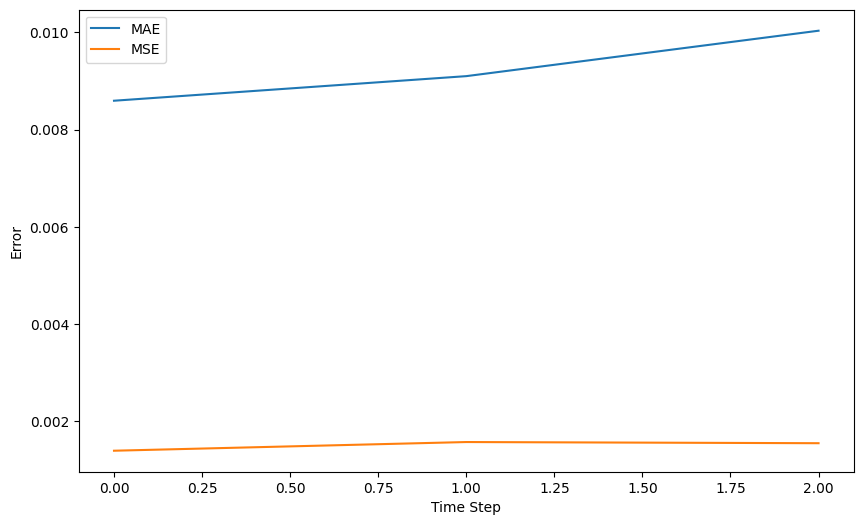

In [57]:
import matplotlib.pyplot as plt

# MAE와 MSE 값 계산
mae = np.mean(np.abs(y_test - y_pred), axis=0)
mse = np.mean(np.square(y_test - y_pred), axis=0)

# 그래프 그리기
plt.figure(figsize=(10,6))
plt.plot(mae, label='MAE')
plt.plot(mse, label='MSE')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.legend()
plt.show()


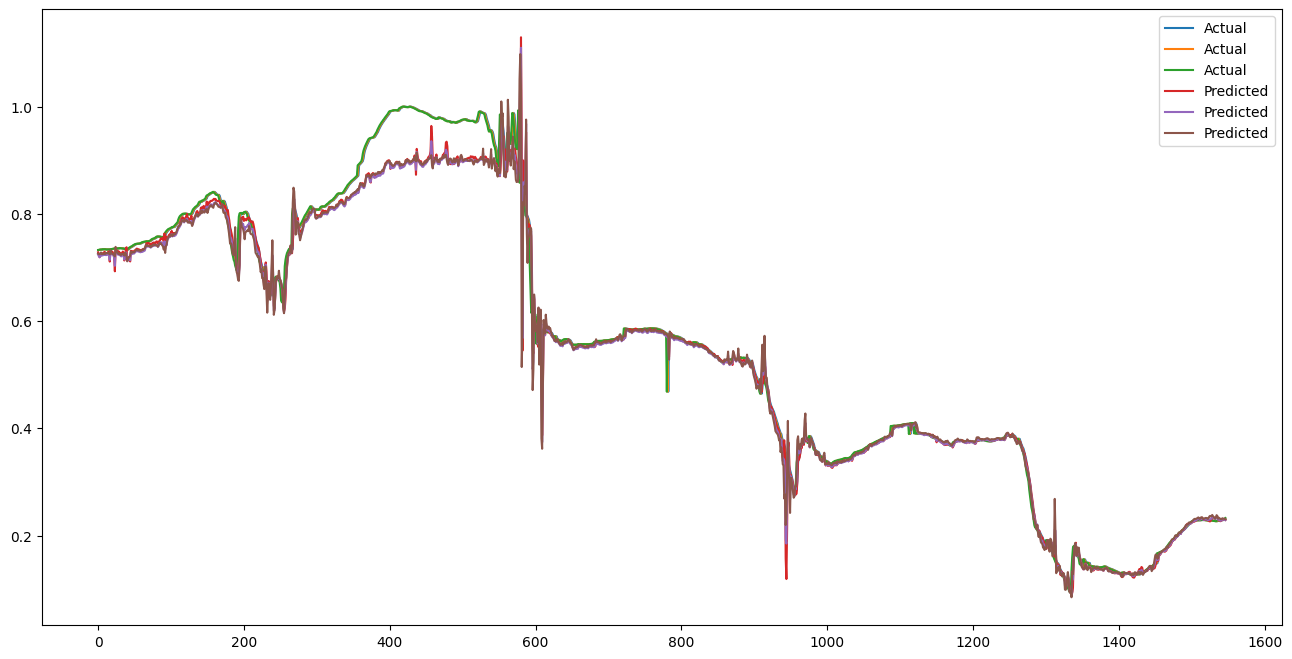

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


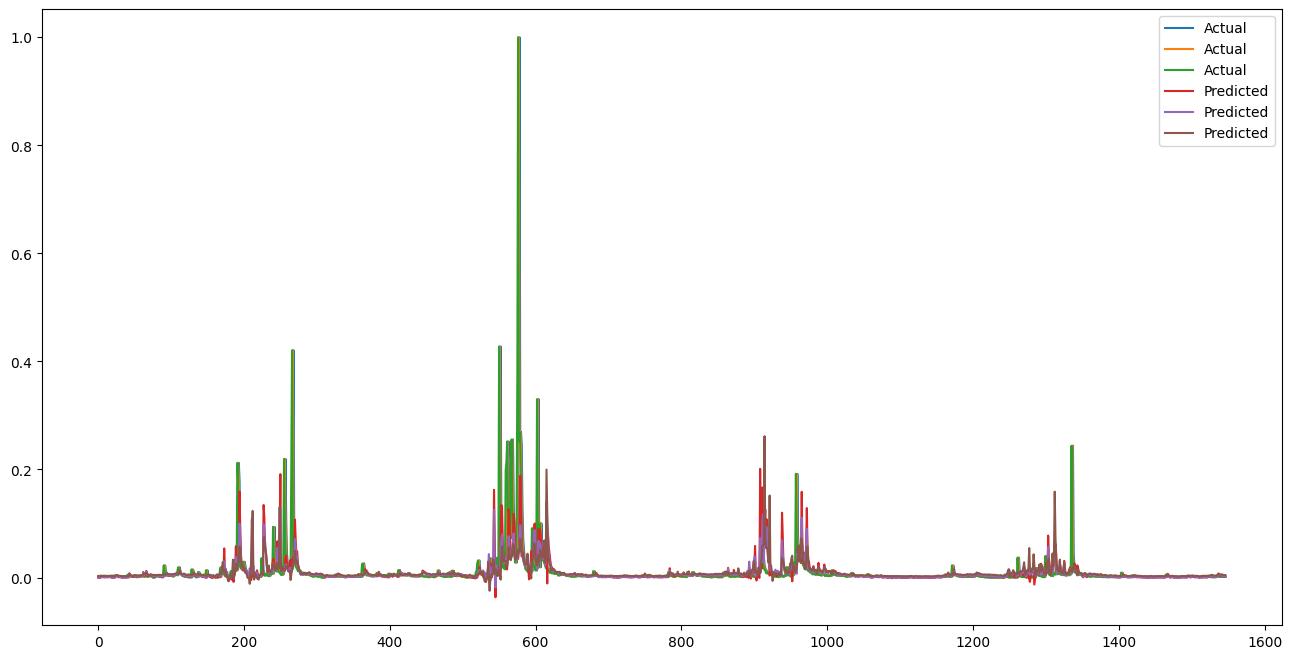

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [75]:
#y_test_original = scaler.inverse_transform(y_test[0])
y_test_df = pd.DataFrame(y_test)
#y_test_df.head()
y_pred_df = pd.DataFrame(y_pred)
test.index #1556
y_test_df.shape #1547

(1547, 3)

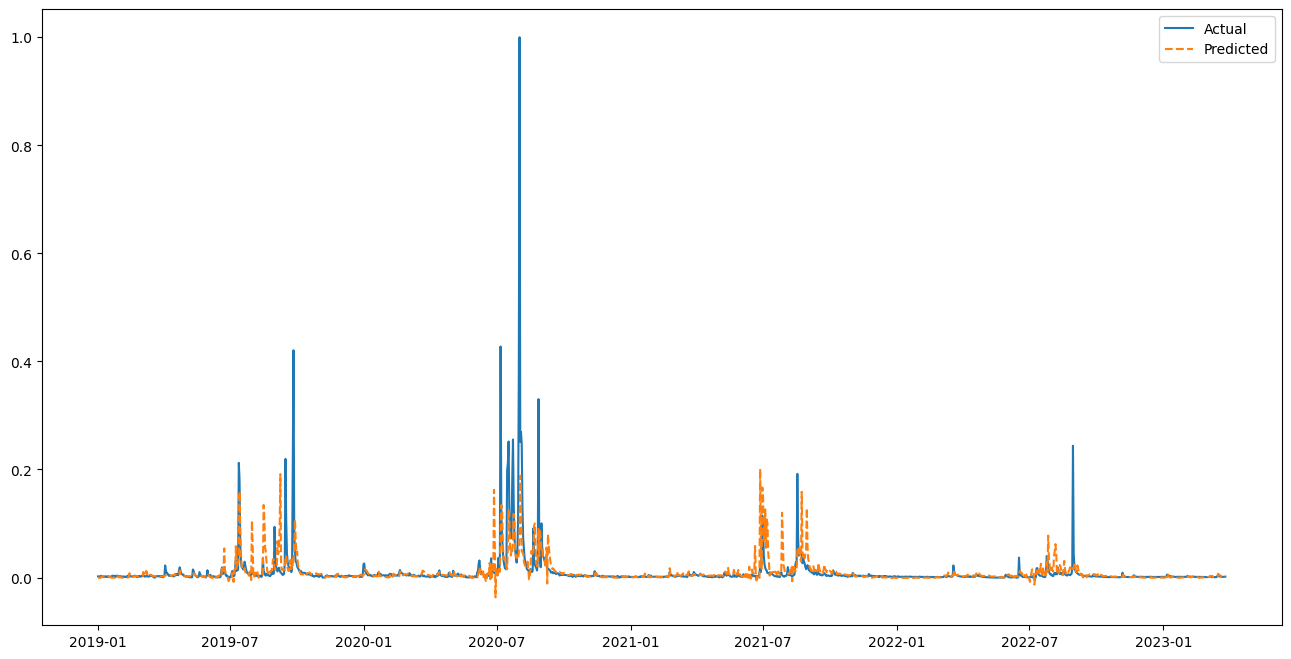

In [76]:
import matplotlib.pyplot as plt
test_dates = df_scaled.index[n_steps_in+len(X_train)+n_steps_out-1:n_steps_in+len(X_train)+n_steps_out-1+len(X_test)]


plt.figure(figsize=(16,8))
plt.plot(test_dates, y_test_df.iloc[:, 0], label='Actual')
plt.plot(test_dates, y_pred_df.iloc[:, 0], label='Predicted', linestyle='--')
plt.legend()
#plt.title('당일 유입량 예측')
plt.show()

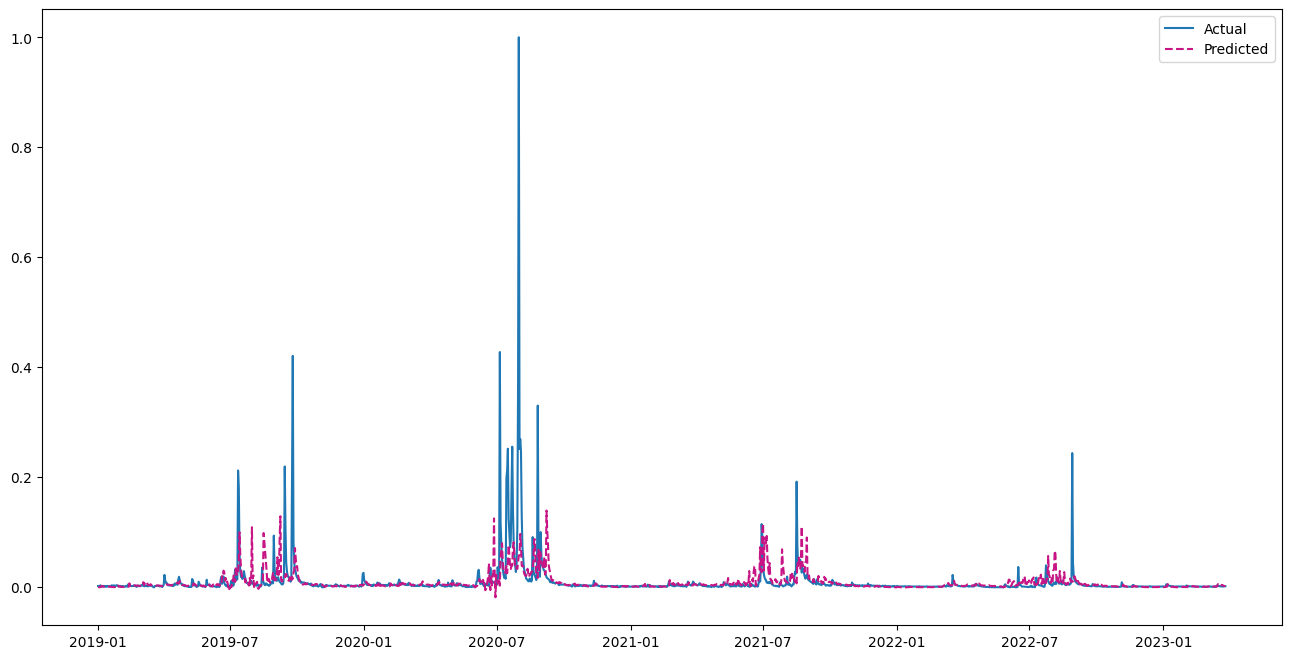

In [78]:
import matplotlib.pyplot as plt
test_dates = df_scaled.index[n_steps_in+len(X_train)+n_steps_out-1:n_steps_in+len(X_train)+n_steps_out-1+len(X_test)]


plt.figure(figsize=(16,8))
plt.plot(test_dates, y_test_df.iloc[:, 1], label='Actual')
plt.plot(test_dates, y_pred_df.iloc[:, 1], label='Predicted', linestyle='--', color='#C71585')
plt.legend()
#plt.title('1일 후 유입량 예측')
plt.show()

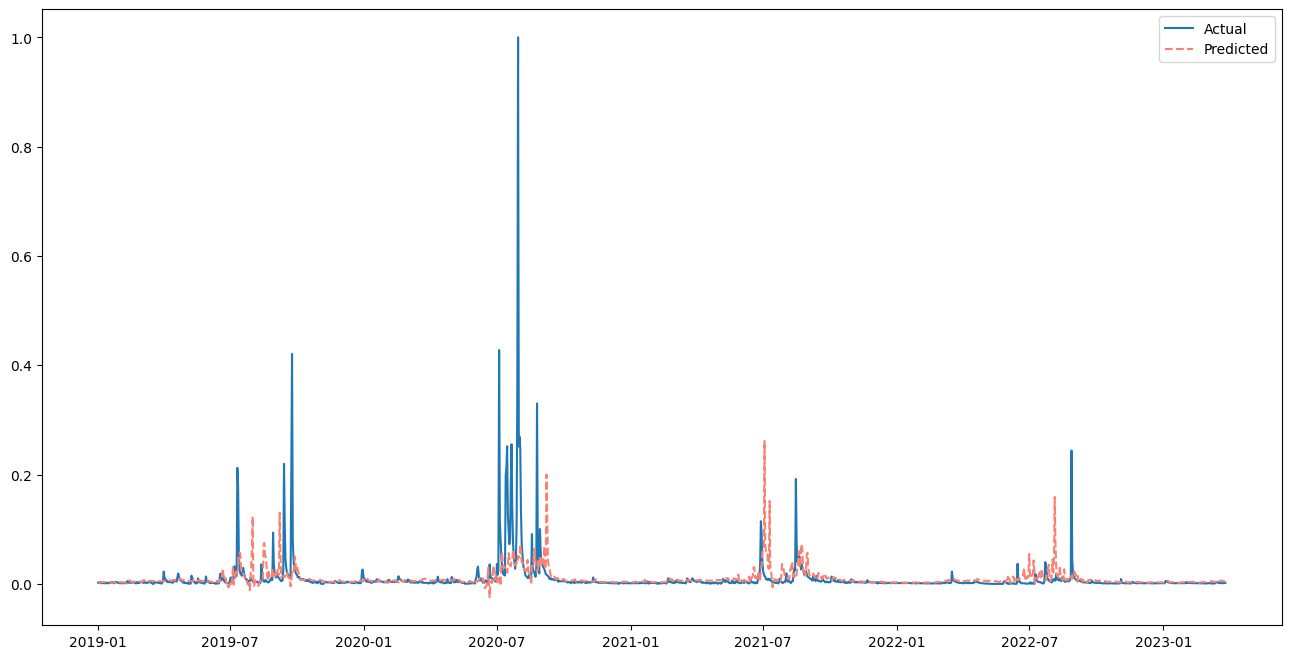

In [79]:
import matplotlib.pyplot as plt
test_dates = df_scaled.index[n_steps_in+len(X_train)+n_steps_out-1:n_steps_in+len(X_train)+n_steps_out-1+len(X_test)]


plt.figure(figsize=(16,8))
plt.plot(test_dates, y_test_df.iloc[:, 2], label='Actual')
plt.plot(test_dates, y_pred_df.iloc[:, 2], label='Predicted', linestyle='--', color='#FA8072')
plt.legend()
#plt.title('2일 후 유입량 예측')
plt.show()

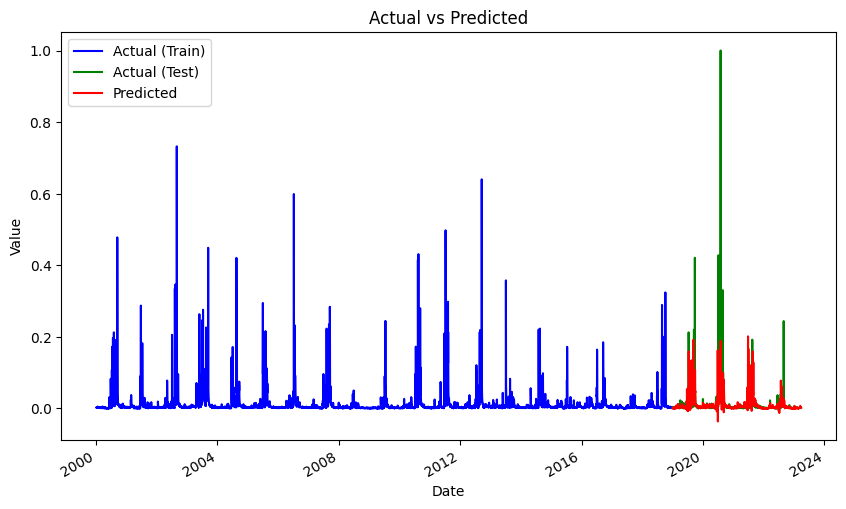

In [80]:
import matplotlib.pyplot as plt

# 날짜 범위 생성
train_dates = df_scaled.index[n_steps_in:n_steps_in+len(X_train)]
test_dates = df_scaled.index[n_steps_in+len(X_train)+n_steps_out-1:n_steps_in+len(X_train)+n_steps_out-1+len(X_test)]

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(train_dates, y_train[:, 0], label='Actual (Train)', color='blue')
plt.plot(test_dates, y_test[:, 0], label='Actual (Test)', color='green')
plt.plot(test_dates, y_pred[:, 0], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()


AttributeError: ignored

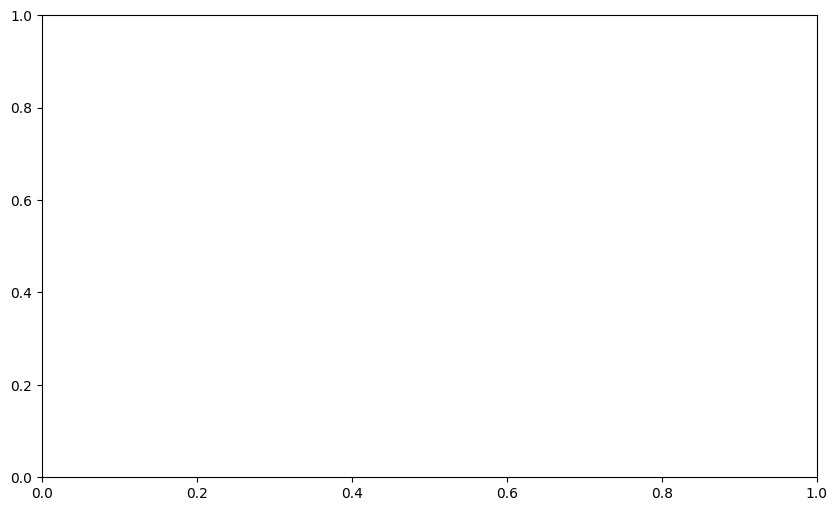

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# 연도별로 날짜 범위 생성
train_years = pd.to_datetime(train_dates).year.unique()
test_years = pd.to_datetime(test_dates).year.unique()

# 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 6))

# 훈련 데이터 그래프 그리기
for year in train_years:
    train_year_dates = train_dates[train_dates.year == year]
    train_year_values = y_train[train_dates.year == year, 0]
    ax.plot(train_year_dates, train_year_values, label=f'Actual (Train) - {year}', color='blue')

# 테스트 데이터 그래프 그리기
for year in test_years:
    test_year_dates = test_dates[test_dates.year == year]
    test_year_values = y_test[test_dates.year == year, 0]
    ax.plot(test_year_dates, test_year_values, label=f'Actual (Test) - {year}', color='green')

# 예측 값 그래프 그리기
ax.plot(test_dates, y_pred[:, 0], label='Predicted', color='red')

# x축 레이블 설정
ax.xaxis.set_major_locator(MultipleLocator(base=365))  # 1년마다 눈금 설정
ax.xaxis.set_major_formatter(plt.FixedFormatter([str(year) for year in train_years]))  # 연도로 표기

# 그래프 설정
ax.set_xlabel('Year')
ax.set_ylabel('Value')
ax.set_title('Actual vs Predicted')
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
print(df_scaled.shape)

(8496, 40)
